# Day 3. Logistic Regression and Classification Metrics

In [2]:
#@title Load the Dataset from Github
!wget https://github.com/UBDS-3/ML_projects_tasks/raw/refs/heads/main/data/fluorescence_dataset.zip
!unzip fluorescence_dataset.zip
!rm -rf fluorescence_dataset.zip

Archive:  fluorescence_dataset.zip
  inflating: fluorescence_dataset.csv  


In [ ]:
#@title Check the Environment for Optimal Experience

#Special thanks to ChatGPT for helping me write this particular cell

%pip install ipywidgets >> ipywidgets_install.log
%pip install statsmodels >> statsmodels_install.log
from IPython.core.magic import register_cell_magic
from IPython.display import display, Markdown, HTML
import ipywidgets as widgets
import sys, traceback

is_colab = 'google.colab' in str(get_ipython())
if is_colab:
  print('Running on Google Colab')
else:
  print('Not running on Google Colab')

@register_cell_magic
def colab_like(line, cell):
    markdown_tag = "#@markdown" + " "
    if not is_colab:
        title = None
        markdown_lines = []
        code_lines = []
        for l in cell.splitlines():
            if l.startswith("#@title "):
                title = l[len("#@title "):].strip()
            elif l.startswith(markdown_tag):
                markdown_lines.append(l[len(markdown_tag):].strip())
            elif l.startswith("# "):
                # skip other comments or include if you want
                pass
            else:
                code_lines.append(l)
        if title:
            display(Markdown(f"### {title}"))
        if markdown_lines:
            display(Markdown('\n'.join(markdown_lines)))

        # Execute the rest of the code
        code_str = '\n'.join(code_lines)
        try:
            exec(code_str, globals())
        except Exception:
            etype, value, tb = sys.exc_info()
            filtered_tb = []
            for frame in traceback.extract_tb(tb):
                if 'colab_like' not in frame.line:
                    filtered_tb.append(frame)

            # Format the traceback into a single string
            traceback_lines = ["Traceback (most recent call last):"]
            for frame in filtered_tb:
                traceback_lines.append(
                    f'  File "{frame.filename}", line {frame.lineno}, in {frame.name}\n    {frame.line}'
                )
            traceback_lines.append(f"{etype.__name__}: {value}")

            # Join and escape HTML
            error_html = "<br>".join(traceback_lines).replace(" ", "&nbsp;")

            # Display in a red box like in Jupyter
            styled_html = f"""
            <div style="
                background-color: #fdd;
                color: black;
                padding: 10px;
                border: 1px solid #f99;
                border-radius: 5px;
                font-family: monospace;
                white-space: pre-wrap;
            ">{error_html}</div>
            """
            display(HTML(styled_html))

#Widget Definitions
if not is_colab:
    slope_slider = widgets.FloatSlider(value=2, min=-5, max=5, step=1, description = "slope")
    intercept_slider = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description = "intercept")
    n_steps_slider = widgets.IntSlider(value=6, min=1, max=11, step=1, description = "n_steps")
    bias_init_slider = widgets.Text(value="0", description = "bias_init")
    deviation_slider = widgets.Text(value="0.001", description = "deviation")
    max_iter_slider = widgets.Text(value="1000", description = "max_iter")
    lr_slider = widgets.Text(value="0.05", description = "lr")
    penalty_slider = widgets.Dropdown(value="l2", options = ["l1", "l2", "elasticnet", "None"], description = "penalty")
    C_slider = widgets.Text(value="1e-01", description = "C")
    solver_slider = widgets.Dropdown(value="newton-cg", options = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"], description = "solver")
    max_iter_slider_2 = widgets.IntSlider(value=1000, min = 0, max = 1000, description = "max_iter")
    n_steps_slider_2 = widgets.IntSlider(value=1000, min = 0, max = 10000, description = "n_steps")

In [ ]:
%%colab_like
#@title Import Necessary Packages
#@markdown How to fill this Jupyter Notebook:
#@markdown 1. For optimal learning experience, Google Colab is recommended (not all notebook displays support the functions used here)
#@markdown 2. All of the tasks are given in the '#@markdown' using the keywords "Finish the Following Tasks"
#@markdown 3. The code you need to input for the tasks should ONLY be put inside the block beginning with `## START HERE` and ending with `## END HERE`
#@markdown 4. The variables mentioned are important for all of the other cells to work, so pay attention to that!
#@markdown 5. If the code doesn't work, don't be afraid to call the TAs!
#@markdown <br>
#@markdown That's it, have fun learning! :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Logistic Regression
Regression Mean Squared Error training behaves well for cases, where we have continuous data type of a target. However, how do we map from continuous inputs to discrete/categorical outputs? After all, they have only a finite number of outcomes, and in most cases, they cannot be ordered into a some sort of scaling (from [ML for Beginners](https://github.com/microsoft/ML-For-Beginners/tree/main)):

<img src = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/refs/heads/main/2-Regression/4-Logistic/images/linear-vs-logistic.png">

For a binary case (only two possible choices - True vs False, Yes vs No, etc.) we use logistic regression, that transforms continuous outputs in the range (-inf, inf) into probabilities (0, 1). The best way to constrict the outputs would be to apply a non-linear function with image (0, 1), like a sigmoid:

$\hat y = \frac{1}{1+e^{-z}},$ where $z = ax+b$ is a linear function with an intercept $b$ and a slope $a$

It is widely used not only in statistics, but also neural network development for intermediate layers (in old models) and final layers for binary classification, so understanding it is crucial for later lessons. Let's begin by seeing the sigmoid function in action!

In [ ]:
%%colab_like
#@title Visualize Linear Regression vs Logistic Regression
#@markdown Finish the Following Tasks:
#@markdown 1. Define variable `x_both`, that contains evenly spaced values from -10 to 10 included
#@markdown 2. Define variable `noise_linear`, that samples from normal distribution with $\mu = 0$ and $\sigma = |slope|$ with shape of `x_both`
#@markdown 3. Define variable `y_linear_ideal`, that takes `x_both` and transforms it using linear formula by using `slope` and `intercept`
#@markdown 3. Define variable `y_linear`, that takes `y_linear_ideal` and adds previously defined noise to it
#@markdown 3. Define variable `y_logistic_ideal`, that takes `y_linear_ideal` and transforms it using a sigmoid (check the formula above)
#@markdown 3. Define variable `y_logistic`, that takes `y_linear` and transforms it using a sigmoid

if is_colab:
    slope = 2 #@param {type:"slider", min:-5, max:5, step:1}
    intercept = 0 #@param {type:"slider", min:-2, max:2, step:0.1}
else:
    widgets.interact(lambda x: None, x = slope_slider)
    slope = slope_slider.value
    widgets.interact(lambda x: None, x = intercept_slider)
    intercept = intercept_slider.value

## START HERE

## END HERE

fig, ax = plt.subplots(1, 2, figsize=(24, 8))

#Linear Regression Plot
ax[0].plot(x_both, y_linear_ideal, c = "r", linestyle = "dashed", linewidth = 4)
ax[0].plot([-intercept/slope, -intercept/slope], [np.min(y_linear), np.max(y_linear)], c = "k", linestyle = "dashed", linewidth = 2)
ax[0].plot([-10, 10], [0, 0], c = "k", linestyle = "dashed", linewidth = 2)
ax[0].scatter(x_both, y_linear, c = "b", s = 25)
ax[0].set_title("Linear Regression")
ax[0].grid()

#Logistic Regression Plot
ax[1].plot(x_both, y_logistic_ideal, c = "r", linestyle = "dashed", linewidth = 4)
ax[1].plot([-intercept/slope, -intercept/slope], [np.min(y_logistic), np.max(y_logistic)], c = "k", linestyle = "dashed", linewidth = 2)
ax[1].plot([-10, 10], [0.5, 0.5], c = "k", linestyle = "dashed", linewidth = 2)
ax[1].scatter(x_both, y_logistic > 0.5, c = "b", s = 25)
ax[1].set_title("Logistic Regression")
ax[1].grid();

The meaning of the coefficients for the linear model were simple. Let's start with the intercept: it is the value of $y$, for which $x = 0$, but it is also proportional (-intercept/slope, check the black dashed line on the plot 0 above) to the value of $x$, where the regression line crosses $y = 0$. You can see this on the image (from this [article](https://medium.com/jungletronics/linear-regressions-the-basics-1a633f351ec2) on Linear Regression) below

<img src = "https://miro.medium.com/v2/resize:fit:786/format:webp/0*MJdfy7jBT0KTXQE0.jpg">

As for the slope, it is the ratio of rise over run, or how fast does the output $y$ change with respect to the input $x$. Now in logistic regression the meanings are somewhat similar:
* The slope corresponds to how fast does the middle of the sigmoid rise with respect to the change in input value, even if the relationship here is no longer one-to-one.
* The intercept here is proportional (-intercept/slope, black dashed line on the plot 1) to the value of the input $x$, where the sigmoid crosses the line $y = 0.5$, or, in other words, for which the model assigns $p(y=True \mid x) = 0.5$

A good question to ask would be: why do we use sigmoid instead of any other function with (0, 1) image? Well, take a look at the next cell!

In [ ]:
%%colab_like
#@title Transforming Probabilities to Log-Odds!
#@markdown Finish the Following Tasks:
#@markdown 1. Create two plots using matplotlib
#@markdown 2. On the first plot, graph the logit function (`log_odds` as a function of `probs`)
#@markdown 3. On the second plot, graph the inverse of the logit function (swap x and y inside the `plot` function) and a sigmoid of `log_odds`
#@markdown 4. Compare the graphs for the logit function, its inverse and the sigmoid.

probs = np.linspace(0, 1, 1001)[1:-1]
odds = probs/(1-probs)
log_odds = np.log(odds)

## START HERE

## END HERE

Sigmoid maps log-odds, that all are in the (-inf, inf) range, to probabilities (0, 1), it is a direct inverse to logit function. In other words, we can perceive logistic regression as a linear regression, that maps from inputs $x$ to log-odds of a probability for belonging to a positive class
$lOdds(y=True \mid x) = ln(\frac{p(y=True \mid x)}{1-p(y=True \mid x)})$, that are then transformed to real probabilities using sigmoid. Since it is an inverse for logit function, and odds are periodically used in statistics to compare probabilities, sigmoid is well-studied and thus perfect for the task

Well, enough theory for now, let's import our dataset and practice!

In [ ]:
%%colab_like
#@title Import the Fluorescence Dataset
#@markdown Finish the Following Tasks:
#@markdown 1. Import the dataset `fluorescence_dataset.csv` from the folder it is in
#@markdown 2. Set it into the variable `dataset`
#@markdown 3. Inspect its first 5 rows

## START HERE

## END HERE

For our goal today, we will try something a bit daring - we will explain, how a protein language model (pLM) works!

This dataset is a prepared variant of one of the [TAPE Benchmark](https://www.biorxiv.org/content/biorxiv/early/2019/06/20/676825.full.pdf) tasks, that analyze, which information pLM embeddings contain. The original dataset by [Sarkisyan et al](https://pmc.ncbi.nlm.nih.gov/articles/PMC4968632/) contains 54025 different GFP mutants matched to their sequences and respective fluorescence values. The modified dataset provided here comprises 78 continuous features preselected from pLM embeddings, that are important for fluorescence prediction, as an $x$ input vector. For $y$ output vector, the file provides log-fluorescence intensity values, with the distribution of values and their binary labels down below (also from [Sarkisyan et al](https://pmc.ncbi.nlm.nih.gov/articles/PMC4968632/#F2)). Using this graph, we would have to convert continuous values to binary labels, signifying dark and light GFP mutants

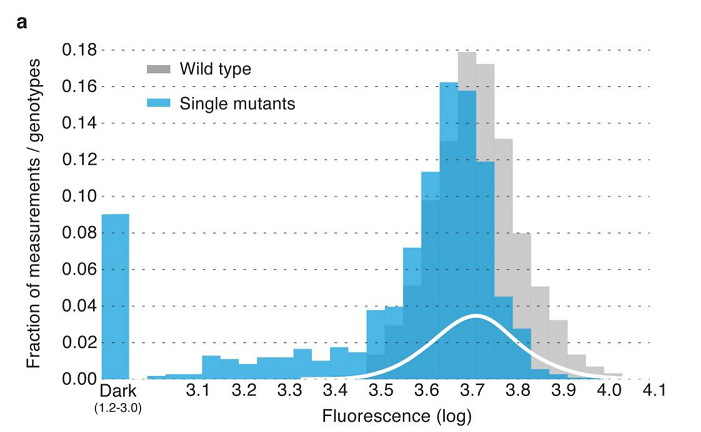

In [ ]:
%%colab_like
#@title Prepare X and Y for Logistic Regression
#@markdown Finish the Following Tasks:
#@markdown 1. Using the inspected dataset, select columns for `x`, `y` and `splits`
#@markdown 2. With the columns defined, select the portions of the dataset into respective variables
#@markdown 3. Compute `x_mean` and `x_std` on `x_train`, after that standardize all of the `x` splits using these values
#@markdown 4. Transform `y` values from continuous to categorical using the graph above and transform `x` and `y` to numpy arrays
#@markdown 5. Using the `splits` Series, split `x` and `y` into train, valid and test, naming them `x_train`, `x_valid`, `x_test` and `y_train`, `y_valid`, `y_test`
#@markdown 6. Inspect `x_train` shape and `y_train` counts of True vs False. You should get the tuple (21446, 78) and a ratio of 17352 Trues vs 4094 Falses

## START HERE

## END HERE

For logistic regression in our multiple input feature case, we need to find 78 slopes ($[a_1, a_2, a_3... a_{78}]$) and 1 intercept ($b$). To do this, we employ a math technique called Maximum Likelihood Estimation (MLE). It sounds scary, but overall the idea is pretty simple. We want to find such values for our model parameters, that increase the probability of seeing the given $y$ values, which decreases an error. If the loss for linear models was given by:
$L = (\hat y - y)^2$, (here $y$ are true Ys and $\hat y$ are predicted Ys), then for this case we have $L = - (y *ln (\hat y) + (1-y) *ln (1 -\hat y))$. We call this Cross-Entropy Loss (CELoss), and it is also widely used in neural network classifier training. Reducing the CELoss is the same as increasing model likelihood

Let's try to implement it ourselves!

In [ ]:
%%colab_like
#@title Cross-Entropy Loss Implementation
#@markdown Finish the Following Tasks:
#@markdown 1. Define the function called `CELoss`, that takes as inputs `y_true` and `y_pred` in that order
#@markdown 2. Inside the definition, compute the Cross-Entropy Loss using the formula given above

## START HERE

## END HERE

#Prepare Arrays for CELoss Plot
if is_colab:
    n_steps = 6 #@param {type:"slider", min:1, max:11, step:1}
else:
    widgets.interact(lambda x: None, x = n_steps_slider)
    n_steps = n_steps_slider.value
y_pred = np.linspace(0, 1, 101)[1:-1]
y_trues = np.linspace(0, 1, n_steps)

#Plot CELoss for Various y_true Values
cmap = plt.get_cmap("jet", n_steps)
for i, y_true in enumerate(y_trues):
    plt.plot(y_pred, CELoss(y_true, y_pred), c = cmap(i), linestyle = "dashed", linewidth = 2)
plt.legend(np.round(y_trues, 3), loc = "center left", bbox_to_anchor = [1, 0.5], title = "True probabilities")
plt.title("Simple Cross-Entropy Loss")
plt.xticks(y_trues, np.round(y_trues, 3))
plt.xlabel("Predicted probability")
plt.ylabel("Loss")
plt.grid();

Intuitively, if the true probability is 1 ($p = 1$), then the minimum of this loss function is at $\hat p = 1$:
<br>
$L = -1*ln(1) - (1-1)*ln(1-1) = -1*0 - 0 = 0$
<br>
And if the true probability is 0 ($p = 0$), then the minimum of this loss function is at $\hat p = 0$:
<br>
$L = -0*ln(0) - (1-0)*ln(1-0) = -0 - 1*0 = 0$
<br>
Note: the infinities emerging at the loss computation can be mostly ignored, as the real model outputs rarely get close to either 0 or 1. This may, however, happen, if the two sets can be perfectly split, resulting in unstable training, coefficient estimates and their covariances - so called "perfect separation". It results in sigmoid adopting a kind of a step function form, which can only occur, if the slope becomes infinitely large (check it in a cell with a sigmoid by progressively increasing the slope from 1 to 5

In [ ]:
%%colab_like
#@title Define Custom Logistic Regression Class

class LogRegressionClassifier():
    '''
    The class for a logistic regression model. Contains slope coefficients (a) and an intercept (b).
    Optimized using gradient descent algorithm with sample weights for each class with respect to CELoss.
    Arguments:
    - n_features: number of input features, used to calculate the shape of a slope array.
    - deviation: the standard deviation of a normal distribution, from which to sample the slope array.
    - bias_init: intercept initial value, can speed up convergence significantly.
    Methods:
    - __init__: the classic object construction method. Its arguments are detailed above. Returns a new
    LogRegressionClassifier object.
    - __call__: call the model to predict the raw probabilities, uses x (input array) as an only argument. Outputs
    only y_hat, or the probabilities per example of belonging to a particular class.
    - train: train the model's coefficients using gradient descent with CELoss. Uses train_set and valid_set
    to compute parameter updates (only for train) and metrics like loss and accuracy (uses both). The sample_weight
    argument allows to train faster for unbalanced datasets by providing means to scale True and False classes,
    respectively. The last parameters concern only the gradient descent optimization: max_iter is the maximum
    number of parameter updates, while lr is a learning rate step for the update. Returns the metrics dictionary
    (contains values per epoch and per dataset split)
    '''
    def __init__(self, n_features, deviation = 1, bias_init = 0):
        self.a = np.random.normal(0, deviation, (1, n_features))
        self.b = bias_init

    def __call__(self, x):
        z = x@self.a.T + self.b
        y_hat = 1/(1+np.exp(-z))
        return y_hat

    def train(self, train_set, valid_set, sample_weight = [1, 1], max_iter = 100, lr = 0.01):
        #Unpack Inputs and Prepare Outputs
        x, y = train_set
        vx, vy = valid_set
        output_dict = {"train_losses":[], "valid_losses":[],
                       "train_accs":[], "valid_accs":[]}

        #Cool Widget Functions
        progress = widgets.IntProgress(value=1, min=1, max=max_iter, description='Training:')
        label = widgets.Label(" 0 % Done")
        display(widgets.HBox([progress, label]))

        #Main Training Loop
        for epoch in range(max_iter):

            #Forward Path
            z = x@self.a.T + self.b
            s = 1/(1+np.exp(-z))
            vz = vx@self.a.T + self.b
            vs = 1/(1+np.exp(-vz))

            #Computing Intermediate Metrics
            l = np.mean(CELoss(y, s))
            vl = np.mean(CELoss(vy, vs))
            acc = np.mean((s > 0.5) == y)
            vacc = np.mean((vs > 0.5) == vy)

            #Derivatives for Gradient Estimation
            dl_ds = -(y/s - (1-y)/(1-s))
            ds_dz = s*(1-s)
            dz_db = 1
            dz_da = x

            #Gradient Estimation and Coefficient Optimization
            sw = sample_weight[0]*y + sample_weight[1]*(1-y)
            grad_a = np.mean(dl_ds*ds_dz*dz_da*sw, 0, keepdims = True)
            grad_b = np.mean(dl_ds*ds_dz*dz_db*sw, 0)
            self.a = self.a - grad_a*lr
            self.b = self.b - grad_b*lr

            #Adding Metrics To a Dictionary
            output_dict["train_losses"].append(l)
            output_dict["valid_losses"].append(vl)
            output_dict["train_accs"].append(acc)
            output_dict["valid_accs"].append(vacc)

            #Display Progress Bar
            progress.value = epoch+1
            label.value = f" {np.round((epoch+1)*100/max_iter, 2)} % Done"

        progress.bar_style = "Success"
        progress.description = "Finish! "

        return output_dict

Here we define our custom logistic regression class - `LogRegressionClassifier`, that takes the number of input features, variance for slope initialization and an initialization for the intercept (bias). The `call` method allows us to predict from $x$ using only parenthesis, like this:
<br>
`log_reg_model = LogRegressionClassifier(5)`
<br>
`y_pred = log_reg_model(x_train)`
<br>
The most complicated part of this code is the `train` method. For logistic regression, there is no analytic formula from MLE, that could help us estimate the coefficients. That is why we use gradient descent here with CELoss (minimizing CELoss with gradient descent is the same as maximizing likelihood using gradient ascent). While there are other methods, that could do the job faster and better (like Newton-Raphson, BFGS/L-BFGS, etc.), gradient descent is simple and is also used to optimize neural networks, so it takes priority. To do gradient descent, either the machine or the model developer has to provide a formula, that is based on this equation:
<br>
$\theta_{i+1} = \theta_{i}-\eta \frac{\partial L}{\partial \theta_{i}}$,
<br>
where $\theta_{i+1}$ is the new version of the parameter, $\theta_{i}$ is the old one, $\eta$ is the learning rate (how big is the update going to be) and $\frac{\partial L}{\partial \theta_{i}}$ is the derivative of CELoss with respect to $\theta_{i}$. Calculating $\frac{\partial L}{\partial \theta_{i}}$ requires a few rounds of the good ol' chain rule from calculus, which, if assembled correctly, points to the direction of the fastest ascent, but with a minus sign it points to the fastest descent of the loss function (check the image below, from this [article](https://medium.com/accredian/gradient-descent-from-the-ground-up-building-your-own-algorithm-from-scratch-a7f608559147)). You don't need to do any derivative computation, all of the components for that are already assembled in the code. After a few rounds of optimization, the model should find the best parameters and stop updating (convergence). Otherwise, something goes wrong and the model has suboptimal performance or even worse, than the baseline (divergence)

<img src = "https://miro.medium.com/v2/resize:fit:720/format:webp/1*yd9YMy2pkzCY-9jrsWFesA.gif">

With all that theory in mind, analyze the code above and the annotations provided to it, after which train the model and output the accuracies per split. We will define fluorescence as $p > 0.5$ and darkness as $p < 0.5$

In [ ]:
%%colab_like
#@title Fit Logistic Regression using Numpy
#@markdown Finish the Following Tasks:
#@markdown 1. Define `LogRegressionClassifier` named `my_log_reg` with 78 `n_features`, given `deviation` for weights initialization and `bias_init` for bias initialization
#@markdown 2. Train it using the predefined training set and validation set (for logging), use the sample weights `sw`, the number of iterations as `max_iter` and learning rate as `lr`. The results of the logging should be set to a variable `output_dict`
#@markdown 3. Compute accuracies per each dataset splits and output them. The naming of variables is mostly not really important, HOWEVER, for test split, log the raw predictions in the variable `y_pred_mlr_raw` and the predicted labels ($p > 0.5$) in `y_pred_mlr`. Those two are going to be used later
#@markdown 4. Analyze the final graphs and accuracies for different splits. What do you think is going on with them?

if is_colab:
    bias_init = 0 #@param {type:"number"}
    deviation = 0.001 #@param {type:"number"}
    max_iter = 10000 #@param {type:"integer"}
    lr = 0.05 #@param {type:"number"}
else:
    widgets.interact(lambda x: None, x = bias_init_slider)
    bias_init = float(bias_init_slider.value)
    widgets.interact(lambda x: None, x = deviation_slider)
    deviation = float(deviation_slider.value)
    widgets.interact(lambda x: None, x = max_iter_slider)
    max_iter = int(max_iter_slider.value)
    widgets.interact(lambda x: None, x = lr_slider)
    lr = float(lr_slider.value)
sw = 1/np.array([np.mean(y_train), 1-np.mean(y_train)])

## START HERE

## END HERE

fig, ax = plt.subplots(1, 2, figsize = (24, 8))

#Plot Loss Change per Epoch
ax[0].plot(output_dict["train_losses"], c = "r", linestyle = "dashed", linewidth = 2)
ax[0].plot(output_dict["valid_losses"], c = "b", linestyle = "dashed", linewidth = 2)
ax[0].set_title("Loss Evolution")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"], borderpad = 1)
ax[0].grid()

#Plot Accuracy Change per Epoch
ax[1].plot(output_dict["train_accs"], c = "r", linestyle = "dashed", linewidth = 2)
ax[1].plot(output_dict["valid_accs"], c = "b", linestyle = "dashed", linewidth = 2)
ax[1].set_title("Accuracy Evolution")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend(["Train", "Test"], borderpad = 1)
ax[1].grid();

By taking the absolute values of feature coefficients in the model (or squaring them, that will also work), we can compute naive feature importance. The reason it is naive is because of two reason. Firstly we need to normalize or standardize the features for this to work, otherwise features with big mean or big deviation can offset the real importances. Fortunately, we already took care of the first problem. Secondly, in case of feature redundancy (this is called multicollinearity, and in ML this is basically always, since we are working with very multidimensional data) there are going to be multiple optimal solutions to the problem of finding model coefficients. So in reality we are plotting only one solution of many, but it can still inform us about how many important features there could be, and what is their distribution:

In [ ]:
%%colab_like
#@title Naive Absolute Feature Importance
plt.figure(figsize = (24, 8))
plt.plot(np.abs(my_log_reg.a.T), c = 'b')
plt.xticks(np.arange(0, x_train.shape[-1], 5))
plt.grid();

Returning to the question of modeling, we don't really need to code the model itself or the optimization process every time we want to perform logistic regression, especially since we have different libraries, that do all of that for us, abstracted away and hidden in the code and documentation. From now on we will be using `scikit-learn` module in Python, that provides ML models as simple and intuitive objects with attributes and methods for training, analyzing accuracy, inference and inspecting weights

In [ ]:
%%colab_like
#@title Fit Logistic Regression in Sklearn
#@markdown Finish the Following Tasks:
#@markdown 1. Import `LogisticRegression` class from `sklearn` module
#@markdown 2. Define an object for LogisticRegression with `penalty = None` (by default it assumes "l2". You will see what that means later)
#@markdown 3. Train it using `fit` method. Note: you will get two warnings: one is about `y_train`, which you should pass into `fit` method as a one-dimensional vector. The other is about an optimization procedure failing, that will be explained later
#@markdown 3. Compute accuracies per each dataset splits and output them. The naming of variables is mostly not really important, HOWEVER, for test split, save the predicted labels ($p > 0.5$) in `y_pred_slr`. Those are going to be used later
#@markdown 4. Analyze the final accuracies for different splits, while also considering the warning. What do you think is going on here?

## START HERE

## END HERE

These results seem pretty bad compared to our model (especially with that warning), but we can significantly improve them, if we analyze LogisticRegression object [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Among the many parameters we can toggle, there are a few, that are of interest:
<br>
`penalty='l2', C=1.0, class_weight=None, solver='lbfgs', max_iter=100`
<br>
What are these? Well, let's analyze them in groups:
1. `class_weight` - Sklearn's equivalent of our sample_weight parameter. We automatically set it to "balanced" to compare with our LogRegressionClassifer model results
2. Regularization group: regularization is adding a special loss term, that punishes the model weights from getting too big, forcing some of them to approach small values (L2-regularization: $||W||^2_2 = \sum W^2$) or even to zero (L1-regularization: $||W||_1 = \sum |W|$). This results in a lowered model complexity, which reduces overfit, but at the possible price of worse accuracy on the training set. `penalty` argument allows us to set a type of regularization, while `C` sets its strength (important: unlike other regularization parameters, increasing`C` **lowers** regularization, while reducing it to fractions closer to 0 **increases** it). This technique is overall very important to ML training (current neural networks use it in the form of weight decay, which is L2-regularization done in the parameter update, not in the loss calculation), so be sure to experiment with it!
3. Solver group: since the computation of logistic regression weights is impossible in analytic form, we use different optimization techniques to get that. Sklearn provides various solvers, which are implementations of optimizers, some of them first order (Stochastic Average Gradient `sag` and its augmented version `saga`), others - second order, requiring Hessian or its approximation (Newton Conjugate Gradient `ncg`, Newton-Cholesky `newton-cholesky` and based on it `liblinear`, BFGS and its limited memory version `lbfgs`). Some of these optimizers converge slowly, and thus require a bigger ammount of maximum allowed iterations for convergence `max_iter`
   
Now that you are familiar with these, try to play around in the cell below, trying to get the model to be as accurate for test set as possible! Note: some optimizers don't play well with regularization, so be sure to check the documentation on the recommended use of regularization with specific optimizers

In [ ]:
%%colab_like
#@title Fit Logistic Regression in Sklearn Again
#@markdown Not really a task, but you should play around here and see, if you can get a better result somehow. The way forward is usually not that obvious, especially in ML, so make sure to always test your assumptions!

if is_colab:
    penalty = 'l2' #@param ["l1", "l2", "elasticnet", "None"]
    C = 1e-01 #@param {type:"number"}
    solver = 'newton-cg' #@param ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
    max_iter = 1000 #@param {type:"integer"}
else:
    widgets.interact(lambda x: None, x = penalty_slider)
    penalty = str(penalty_slider.value)
    widgets.interact(lambda x: None, x = C_slider)
    C = float(C_slider.value)
    widgets.interact(lambda x: None, x = solver_slider)
    solver = str(solver_slider.value)
    widgets.interact(lambda x: None, x = max_iter_slider_2)
    max_iter = int(max_iter_slider_2.value)

class_weight = "balanced"
if penalty == 'None':
    penalty = None

log_reg = LogisticRegression(penalty = penalty, C = C, solver = solver, max_iter = max_iter)
log_reg.fit(x_train, y_train[:, 0])

y_true = y_train
y_pred = log_reg.predict(x_train) > 0.5
acc_train = np.mean(y_pred == y_true)
print(f"Train Accuracy: {np.round(acc_train*100, 3)} %")

y_true = y_valid
y_pred = log_reg.predict(x_valid) > 0.5
acc_valid = np.mean(y_pred == y_true)
print(f"Valid Accuracy: {np.round(acc_valid*100, 3)} %")

y_true = y_test
y_pred = log_reg.predict(x_test) > 0.5
acc_test = np.mean(y_pred == y_true)
print(f"Test Accuracy: {np.round(acc_test*100, 3)} %")

Logistic Regression models are pretty simple compared to some other, more advanced classification techniques, and so they are widely used in statistical analysis of data. The estimation of covariance is done by using the second derivative of the loss with respect to the parameters (Hessian matrix), which points out the curvature of the loss at the particular values of parameters. The whole process is pretty complicated, however, we can use some modules written for this exact purpose, like [StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html). The example here is purely for demonstrational purposes, you don't necessarily need to learn, how to operate this module:

In [ ]:
%%colab_like
#@title Similar Result in StatsModels
from statsmodels.api import Logit, add_constant
x_sm = add_constant(x_train)
y_sm = y_train
sm_model = Logit(y_sm, x_sm)
fitted_model = sm_model.fit()

y_true = y_train
y_pred = fitted_model.predict(add_constant(x_train)) > 0.5
acc_train = np.mean(y_pred == y_true)
print(f"Train Accuracy: {np.round(acc_train*100, 3)} %")

y_true = y_valid
y_pred = fitted_model.predict(add_constant(x_valid)) > 0.5
acc_valid = np.mean(y_pred == y_true)
print(f"Valid Accuracy: {np.round(acc_valid*100, 3)} %")

y_true = y_test
y_pred_smr = fitted_model.predict(add_constant(x_test)) > 0.5
acc_test = np.mean(y_pred_smr == y_true)
print(f"Test Accuracy: {np.round(acc_test*100, 3)} %")

#Get a Summary, Shorten It and Print It
summaries = fitted_model.summary()
print(summaries.tables[0])
print("\n".join(summaries.tables[1].as_text().split("\n")[:9]))
print("...")

There are a lot of things going on here, but for now we will focus on the coefficients of the model. As we mentioned before, the feature coefficients (`coef` column for `x1, x2, x3, x4, x5...`) of the logistic regression model define the steepness of the sigmoid curve, while the bias (`const`) is an offset, that positions the curve's center (`p = 0.5`). To not confuse the coefficients with actual x1, x2 and other values in x, let's use `w1, w2, w3, w4, w5...`. However here we also see some other parameters related to those feature coefficients, like `std err`, `z`, `P>|z|` and `[0.025 0.975]`. These are statistical parameters, like the standard error of the coefficient $SEM$, respective $z$ score, probabilitity of coefficient like this or bigger in abs value occuring under the null hypothesis $H_0$ stating $w_1 = 0$, or just p value and two percentiles for confidence intervals: 2.5 and 97.5 percentiles. To get these results, we use statistical testing formulas (assuming normal distribution) on a bias estimation:

`z_b = coef / std_err = -10.5704 / 2.250 = -4.698`
<br>
`p(|z| >= |z_b| given N, mu=0, sigma=1) = 0.000002627` (calculator)
<br>
`lower_bound(b, 2.5%) = coef - z_threshold*std_err = -10.5704 - 1.96*2.250 = -14.9804`
<br>
`upper_bound(b, 97.5%) = coef + z_threshold*std_err = -10.5704 + 1.96*2.250 = -6.1604`

With our rough numbers - close enough. Since all our confidence intervals do not include 0 and p value is well below 0.05 threshold, it is clear, that $const$ is most likely not zero.  There are some issues here, that StatsModels doesn't really account for, like the fact, that we have 79 (78 feature coefficients and 1 bias) comparisons to zero, so we need to correct for that. But overall the interpretation of statistical values here doesn't differ from the regular linear regression. The difference is how we get here - not using explicit analytic formulas, but with nonlinear optimization. After all, while we know, how the `coef` column is calculated, `std_err` column itself is calculated from the covariance matrix, which itself is derived from the Hessian, as mentioned before. This is somewhat different compared to how it is done in linear regression, especially since it requires the algorithm to converge. Otherwise, we can't get good covariance estimates.

Now that we have 3 different logistic regression models on our hands, we can now go to analyzing their results in detail and see, how we can compare all three in terms of performance

## Part 2. Model Metrics Computation
So, now that we trained our logistic regression model, how do we analyze, if it is doing good or bad, and if it is doing bad, pinpoint the exact issue? Well, we have multiple different metrics, that could be useful for debugging.
Since logistic regression is a statistical classification model, there were different attempts to generalize $R^2$ from linear models, that are known as Pseudo-$R^2$. Most commonly used now is McFadden's Pseudo-$R^2$:

$R^2_{McF} = 1 - \frac{ln(L_{model})}{ln(L_{null})}$

Here we compare the model's performance (as log-likelihood $ln(L_{model})$) with that of a dummy model (as log-likelihood $ln(L_{null})$), that only fits the mean of the whole dataset. It is a "Pseudo"-$R^2$, because if the model is somehow worse, than the null, $R^2_{McF}$ can become less than 0, thus deviating from linear regression's true $R^2$


In [ ]:
%%colab_like
#@title Display the Summary from StatsModels
print(fitted_model.summary().tables[0])

From the StatsModels summary above, we can take the numbers given, compute our own McFadden's Pseudo-$R^2$ and compare it with the result from StatsModels:

In [ ]:
%%colab_like
#@title Computing Pseudo-R2 from StatsModels
#@markdown Finish the Following Tasks:
#@markdown 1. Take a look at the table above and note the following values: pseudo-R2, model log-likelihood, null log-likelihood
#@markdown 2. Once you have found them, set the variables for them, compute pseudo-R2 using the formula above and compare it to the one in StatsModels

## START HERE

## END HERE

There are, however, a lot of other metrics for classifiers, that are not necessarily statistical. You already learned two of them: CELoss (or just model loss) and accuracy. CELoss requires raw probabilities to function, while accuracy uses only the final label. The computation of accuracy is fairly simple - it is the number of correct predictions over all predictions:

$Acc = \frac{Correct}{Correct+Incorrect} = \frac{TP + TN}{TP + TN + FP + FN}$

This formula seems scary for something as simple as accuracy, but once again, don't worry - what it means is that we take the correct predictions and divide them by all predictions made by the model. For the correct predictions, there are two groups: correctly predicted as Positive - True Positive, and correctly predicted as Negative - True Negative. For all predictions, we have correct and incorrect predictions. In incorrect predictions, we have two groups again: incorrectly predicted as Positive - False Positive, and incorrectly predicted as Negative - False Negative. These groups are important to understand, as we then use them to define other metrics, like Precision, Recall and F1-score.

One way to visualize these 4 groups is by using a confusion matrix (from this [tutorial](https://ds100.org/course-notes-su23/logistic_regression_2/logistic_reg_2.html), really recommend these):

<img src = "https://ds100.org/course-notes-su23/logistic_regression_2/images/confusion.png">

In [ ]:
%%colab_like
#@title Using Confusion Matrix to Visualize Model Errors
#@markdown Finish the Following Tasks:
#@markdown 1. Create the list `labels` that contains two strings: "No Light" and "Light"
#@markdown 2. Import `confusion_matrix` and `ConfusionMatrixDisplay` from `sklearn`
#@markdown 3. This is the reason why you were asked to save your test split predictions. Use `y_pred_mlr`, `y_pred_slr` and `y_pred_smr` to compute respective [confusion_matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) as arrays. Set the results for `y_pred_mlr` to `confusion_matrix_mlr`
#@markdown 4. Visualize all three using `ConfusionMatrixDisplay` and use `labels` as displayed labels, after which plot them without the colorbar and using a colormap of your choice ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html))


## START HERE

## END HERE

The difference between all 4 groups is how the predicted label corresponds with the actual label in the dataset. If the predicted label is the same as the real label, it belongs in the T group: TP for True Positive and TN for True Negative. True values are situated along the main diagonal in the confusion matrix, with TP on the lower right and the TN on the upper left (it is because the confusion matrix defaults to [0, 1] order of labels). The errors (F group) are situated to the sides of the main diagonal, with FP on the upper right and FN on ther lower left

Note: These two errors types also arise in many statistical techniques you would use, e.g. for statistical hypothesis testing, the threshold probability ($\alpha$) is defined as the maximum possible FP rate (Type I Error) given the test is performed correctly. Recently statisticians are taking more and more interest in reducing FN rate (Type II Error) too, in such a way, which would not compromise FP rate (that is only possible by increasing the sample size)

Let's check other metrics, like Precision, Recall and F1-score. They are pretty simple definitionally:
<br>
$Prc_P=\frac{TP}{TP+FP}$ (the ratio of True Positives among all the Positives (TP+FP) predicted by the model)
<br>
$Rec_P=\frac{TP}{TP+FN}$ (this is also called sensitivity; the ratio of True Positives among all the real Positives, or TP+FN, with FN being an incorrectly predicted Negative, meaning in reality, it is a Positive)
<br>
$F1_P=\frac{2}{\frac{1}{Prc}+\frac{1}{Rec}}=\frac{TP}{TP+\frac{1}{2}(FN+FP)}$ (a combination of precision and recall, that encourages both of them to be similar in value)

Note: the Positive label can be swapped for Negative in the computation of these, which would give:
<br>
$Prc_N=\frac{TN}{TN+FN}$
<br>
$Rec_N=\frac{TN}{TN+FP}$ (for binary case this is also called specificity; remember, we used the real Positives in the previous formula, so here we need real Negatives, so we swap FN for FP!)
<br>
$F1_N=\frac{2}{\frac{1}{Prc}+\frac{1}{Rec}}=\frac{TN}{TN+\frac{1}{2}(FN+FP)}$
<br>

We can compute all of these from the definitions and compare it to sklearn's classification_report (to make this simpler, let's focus only on LogRegressionClassifier predictions):

In [ ]:
%%colab_like
#@title Computing Classification Report and Confusion Matrix By Hand
#@markdown Finish the Following Tasks:
#@markdown 1. Compute TP, TN, FP and FN rates using `y_pred_mlr`
#@markdown 2. Using the visualization above, create an array for the confusion matrix and store it in the variable `our_confusion_matrix`
#@markdown 3. Compute precision, recall and F1-score for both labels
#@markdown 4: Import `classification_report` from `sklearn`
#@markdown 5. In the second block, compute `classification_report` using `y_test`, `y_pred_mlr` and given label names ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html))

## START HERE

## END HERE

class_report_arr = np.round(np.array([[precision_neg, recall_neg, f1_neg],
                                      [precision_pos, recall_pos, f1_pos]]), 2)
class_report_df = pd.DataFrame(class_report_arr, columns = ["precision", "recall", "f1-score"], index = labels)
print("Confusion Matrix Computed using Formulas:")
print(our_confusion_matrix)
print("Confusion Matrix Computed by Sklearn: ")
print(confusion_matrix_mlr)
print()
print("Classification Report Computed using Formulas:")
print(class_report_df)
print()
print("Classification Report Computed using Sklearn:")

## START HERE

## END HERE

The final metric we will tackle for today is AUROC. It stands for "Area under Receiver Operating Characteristic Curve". This seems a lot, so let's untangle this one by one. The Receiver Operating Characteristic Curve is a graph we get, if we take our classifier probabilistic predictions and apply different thresholds for what is considered belonging to the True or False label. E.g in previous section we applied a threshold of 0.5 to our probabilities in order to convert them to those two labels. However, other thresholds are possible, and as a result, we will have varying rates of TP and FP groups (this is a characteristic, that doesn't depend on the y_true label, so calculating it for Negative results in the same value). The resultant plot is TP as a function of FP. Let's try implementing it ourselves!

In [ ]:
%%colab_like
#@title Implementing ROC Plot for LogRegressionClassifier
#@markdown Finish the Following Tasks:
#@markdown 1. Using `numpy`, compute an array of evenly spaced values between 0 and 1. These will be our thresholds
#@markdown 2. Define an array of zeros called `group_rates`, that has the sam length as thresholds and can hold three values in each row
#@markdown 3. In a loop, we take `y_pred_mlr_raw`, apply a threshold for it, compute `fp` = FP/(Real N) and `tp` = TP/(Real P), after which we log [threshold, fp, tp] into `group_rates`
#@markdown 4. Transform `group_rates` array into a DataFrame with columns `["threshold", "fp", "tp"]`

if is_colab:
    n_steps = 1000 #@param {type:"integer"}
else:
    widgets.interact(lambda x: None, x = n_steps_slider_2)
    n_steps = int(n_steps_slider_2.value)

## START HERE

## END HERE

#Plot Loss Change per Epoch
plt.plot(group_rates["fp"], group_rates["tp"], c = "r", linestyle = "solid", linewidth = 2)
plt.plot([0, 1], [0, 1], c = "k", linestyle = "dashed", linewidth = 2)
plt.title("ROC for LogRegressionClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

The comparison is with the random classifier, that would have this curve close to a straight line from (0, 0) to (1, 1). The reason is that if we increase the threshold and have the same increase in FP and TP (instead of having big increase for TP with a small increase in FP), then it means we have 50/50 chance of getting a correct prediction vs incorrect for Positive label, suggesting the accuracy of a random guess. We can compute the area under this curve, since we have a finite number of steps (either because of a loop using a predefined step or the restricted number of samples) using the rule for integration:

$AUC(f, a, b) = \int_a^b f(x) dx \approx \sum f(x)\Delta x $

Note: some of the values for FP are redundant, resulting in the same x values mapping to y. Since this messes up our computations somewhat, let's first group TP values by FP values, compute the means for TP with respect to the same FP, and only then compute steps and function values

By now we should be able to compute this ourselves and compare it to Sklearn implementation:

In [ ]:
%%colab_like
#@title Computing AUROC and Comparing It to Sklearn Version
#@markdown Finish the Following Tasks:
#@markdown 1. Clean `group_rates` from the same FP rates using groupby on it, and then computing a mean for TP. Also don't forget to sort the FPs!
#@markdown 2. Compute steps for our integration: take FP rates, then get a difference between each two closest FP rates
#@markdown 3. Take TP rates as function values, then compute the mean for two closest ones
#@markdown 4. Our AUROC will be the sum of the elementwise product of steps and functions (check the formula for integration above)
#@markdown 5. Import `roc_auc_score` function from `sklearn` module and use it to compare our AUROC vs the Sklearn implementation

## START HERE

## END HERE

## Materials for Further Study
* [Videos](https://www.youtube.com/playlist?list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe) by StatQuest describing in detail, how Logistic Regression works
* [Videos](https://www.youtube.com/playlist?list=PLczNrmMT94oGSzzq47RWrG_74EPi15XYZ) by an associate professor of Physical Faculty of KNU Tymofii Nikolaienko describing optimization algorithms with math
* [Video](https://www.youtube.com/watch?v=ARfXDSkQf1Y) by StatQuest with formulas and intuitive examples for odds and log-odds
* [Video](https://www.youtube.com/watch?v=IHZwWFHWa-w) by 3Blue1Brown explaining Gradient Descent using animation
* [Article](https://www.geeksforgeeks.org/machine-learning/understanding-logistic-regression/) by GeeksForGeeks about all the topics covered here and slightly more!
* [Article](https://www.geeksforgeeks.org/machine-learning/logistic-regression-using-statsmodels/) by GeeksForGeeks about performing Logistic Regression in StatsModels
* [Article](https://www.geeksforgeeks.org/deep-learning/second-order-optimization-methods/) by GeeksForGeeks about different Second Order Optimizers
* [User Guide](https://www.statsmodels.org/stable/gettingstarted.html) by StatsModels in case you want to use Logistic Regression for statistical parameter estimation in Python
* [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) by Sklearn about the math of Logistic Regression and how to perform it (especially since the class LogisticRegression can also be used for multinomial case not brought up here)
* [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) by Sklearn about different metrics used for classification, how to call them and for what purposes. It goes way into detail, describing many more metrics, that we covered here